# Permanent Visa Application Analysis

The main question we are interested in answering from this dataset is how well the labor certification agency follows criteria in granting visas. That is:
1. Does the offering wage have to be over the prevailing wage for the application to be approved?
2. Was the position advertised in newspapers ads on two seperate occassions in the specified time-frame?

And in addition to requirements set by the agency, what other factors are important determinants of application approval? Such as
1. The employer / law firm representing the employer
2. Job position that the visa applicant will fill

# Import Modules

In [285]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import h2o
from h2o.estimators import random_forest
from h2o.frame import H2OFrame

import sklearn
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

%matplotlib inline

# Read Data

In [286]:
path = 'G:/gdev/Documents/research/Data/'
visas = pd.read_excel(path + 'PERM_Disclosure_Data_FY2018_Q4_EOY.xlsx', thousands=',')

#data obtained from https://www.foreignlaborcert.doleta.gov/performancedata.cfm

In [287]:
print(visas.shape)

(119776, 125)


# Exploratory Data Analysis

In [288]:
print(visas['CASE_STATUS'].value_counts())

Certified            72187
Certified-Expired    37363
Denied                6255
Withdrawn             3971
Name: CASE_STATUS, dtype: int64


The data has 1199776 observations and 125 features including our target variable 'CASE_STATUS'.
Although we technically have 4 classes, we'll only be using 'Certified' and 'Denied' statuses and so this will be a binary classification problem.
We can see that this is an imbalanced dataset and most applicants are actually accepted.

In [289]:
pd.set_option('display.max_columns', None)
visas.head(5)

,CASE_NUMBER,DECISION_DATE,CASE_STATUS,CASE_RECEIVED_DATE,REFILE,ORIG_FILE_DATE,ORIG_CASE_NO,SCHD_A_SHEEPHERDER,EMPLOYER_NAME,EMPLOYER_ADDRESS_1,EMPLOYER_ADDRESS_2,EMPLOYER_CITY,EMPLOYER_STATE,EMPLOYER_COUNTRY,EMPLOYER_POSTAL_CODE,EMPLOYER_PHONE,EMPLOYER_PHONE_EXT,EMPLOYER_NUM_EMPLOYEES,EMPLOYER_YR_ESTAB,FW_OWNERSHIP_INTEREST,AGENT_FIRM_NAME,AGENT_CITY,AGENT_STATE,PW_TRACK_NUM,PW_SOC_CODE,PW_SOC_TITLE,PW_LEVEL_9089,PW_AMOUNT_9089,PW_UNIT_OF_PAY_9089,PW_SOURCE_NAME_9089,PW_SOURCE_NAME_OTHER_9089,PW_DETERM_DATE,PW_EXPIRE_DATE,WAGE_OFFER_FROM_9089,WAGE_OFFER_TO_9089,WAGE_OFFER_UNIT_OF_PAY_9089,JOB_INFO_WORK_CITY,JOB_INFO_WORK_STATE,JOB_INFO_WORK_POSTAL_CODE,JOB_INFO_JOB_TITLE,JOB_INFO_EDUCATION,JOB_INFO_EDUCATION_OTHER,JOB_INFO_MAJOR,JOB_INFO_TRAINING,JOB_INFO_TRANING_NUM_MONTHS,JOB_INFO_TRAINING_FIELD,JOB_INFO_EXPERIENCE,JOB_INFO_EXPERIENCE_NUM_MONTHS,JOB_INFO_ALT_FIELD,JOB_INFO_ALT_FIELD_NAME,JOB_INFO_ALT_COMBO_ED_EXP,JOB_INFO_ALT_COMBO_ED,JOB_INFO_ALT_COMBO_ED_OTHER,JOB_INFO_ALT_CMB_ED_OTH_YRS,JOB_INFO_FOREIGN_ED,JOB_INFO_ALT_OCC,JOB_INFO_ALT_OCC_NUM_MONTHS,JOB_INFO_ALT_OCC_JOB_TITLE,JOB_INFO_JOB_REQ_NORMAL,JOB_INFO_FOREIGN_LANG_REQ,JOB_INFO_COMBO_OCCUPATION,JI_OFFERED_TO_SEC_J_FW,JI_FW_LIVE_ON_PREMISES,JI_LIVE_IN_DOMESTIC_SERVICE,JI_LIVE_IN_DOM_SVC_CONTRACT,RECR_INFO_PROFESSIONAL_OCC,RECR_INFO_COLL_UNIV_TEACHER,RECR_INFO_COLL_TEACH_COMP_PROC,RI_COLL_TCH_BASIC_PROCESS,RI_COLL_TEACH_SELECT_DATE,RI_COLL_TEACH_PRO_JNL,RECR_INFO_SWA_JOB_ORDER_START,RECR_INFO_SWA_JOB_ORDER_END,RECR_INFO_SUNDAY_NEWSPAPER,RI_1ST_AD_NEWSPAPER_NAME,RECR_INFO_FIRST_AD_START,RI_2ND_AD_NEWSPAPER_NAME,RI_2ND_AD_NEWSPAPER_OR_JOURNAL,RECR_INFO_SECOND_AD_START,RECR_INFO_JOB_FAIR_FROM,RECR_INFO_JOB_FAIR_TO,RECR_INFO_ON_CAMPUS_RECR_FROM,RECR_INFO_ON_CAMPUS_RECR_TO,RI_EMPLOYER_WEB_POST_FROM,RI_EMPLOYER_WEB_POST_TO,RECR_INFO_PRO_ORG_ADVERT_FROM,RECR_INFO_PRO_ORG_ADVERT_TO,RI_JOB_SEARCH_WEBSITE_FROM,RI_JOB_SEARCH_WEBSITE_TO,RI_PVT_EMPLOYMENT_FIRM_FROM,RI_PVT_EMPLOYMENT_FIRM_TO,RI_EMPLOYEE_REFERRAL_PROG_FROM,RI_EMPLOYEE_REFERRAL_PROG_TO,RI_CAMPUS_PLACEMENT_FROM,RI_CAMPUS_PLACEMENT_TO,RI_LOCAL_ETHNIC_PAPER_FROM,RI_LOCAL_ETHNIC_PAPER_TO,RECR_INFO_RADIO_TV_AD_FROM,RECR_INFO_RADIO_TV_AD_TO,RECR_INFO_EMPLOYER_REC_PAYMENT,RECR_INFO_BARG_REP_NOTIFIED,RI_POSTED_NOTICE_AT_WORKSITE,RI_LAYOFF_IN_PAST_SIX_MONTHS,RI_US_WORKERS_CONSIDERED,FOREIGN_WORKER_INFO_CITY,FOREIGN_WORKER_INFO_STATE,FW_INFO_POSTAL_CODE,COUNTRY_OF_CITIZENSHIP,FW_INFO_BIRTH_COUNTRY,CLASS_OF_ADMISSION,FOREIGN_WORKER_INFO_EDUCATION,FW_INFO_EDUCATION_OTHER,FOREIGN_WORKER_INFO_MAJOR,FW_INFO_YR_REL_EDU_COMPLETED,FOREIGN_WORKER_INFO_INST,FW_INFO_TRAINING_COMP,FW_INFO_REQ_EXPERIENCE,FW_INFO_ALT_EDU_EXPERIENCE,FW_INFO_REL_OCCUP_EXP,PREPARER_INFO_EMP_COMPLETED,PREPARER_INFO_TITLE,EMPLOYER_DECL_INFO_TITLE,NAICS_US_CODE,NAICS_US_TITLE,PW_JOB_TITLE_9089
0,A-17268-91243,2017-10-01,Withdrawn,2017-09-29,N,NaT,NaN,N,DATA MEANING SERVICES GROUP,3301 NORTH UNIVERSITY DRIVE,SUITE 400,CORAL SPRINGS,FL,UNITED STATES OF AMERICA,33065,8554243282,NaN,29.0,2010.0,N,AULAKH FERGUSON,Washington,DC,P10017073123803,15-1132,"Software Developers, Applications",Level III,82368.00,Year,OES,NaN,2017-06-12,2017-09-10 00:00:00,82368.00,NaN,Year,Coral Springs,FL,33065,Web Architect,None,NaN,NaN,N,NaN,NaN,Y,24.0,N,NaN,N,NaN,NaN,NaN,N,NaN,NaN,NaN,Y,Y,N,Y,N,N,NaN,Y,N,NaN,NaN,NaT,NaN,2017-07-07,2017-08-07 00:00:00,Y,Sun Sentinel,2017-07-09,Sun Sentinel,Y,2017-07-16,NaT,NaT,NaT,NaT,2017-07-07,2017-09-26,NaT,NaT,2017-07-18,2017-08-18,NaT,NaT,NaT,NaT,NaT,NaT,2017-07-19,2017-07-26,NaT,NaT,N,A,Y,N,NaN,CORAL SPRINGS,FL,33065,BRAZIL,BRAZIL,H-1B,High School,NaN,GENERAL,2001.0,EE DOROTHOVEO GASPAR VIANNA PROF,A,Y,A,A,N,Counsel,Human Capital Manager,541511,Custom Computer Programming Services,Web Architect
1,A-17268-91198,2017-10-01,Withdrawn,2017-09-29,N,NaT,NaN,N,NOVO NORDISK INC.,800 SCUDDERS MILL ROAD,NaN,PLAINSBORO,NJ,UNITED STATES OF AMERICA,08536,609-987-5800,NaN,5234.0,1982.0,N,"Morgan, Lewis & Bockius LLP",Washington,DC,P10016267864760,15-1121,Comput

We can see some of the features above, and many of them seem like they'll be useful in predicting the status of applications. However, because we can rank feature importance by their contribution to the model that we'll build let's do a first pass just to get a feel of the data and defer deeper analysis into individual features until later.

Looking at the field descriptions that came with the data, we decide to start out with the wages offered by the firms sponsoring the visa applicants because we think that may be a major factor in determining acceptance.

In [290]:
col_ofint = ['PW_AMOUNT_9089', 'WAGE_OFFER_FROM_9089', 'WAGE_OFFER_TO_9089', 'PW_UNIT_OF_PAY_9089', 'WAGE_OFFER_UNIT_OF_PAY_9089']
print(visas[col_ofint].dtypes)

PW_AMOUNT_9089                  object
WAGE_OFFER_FROM_9089            object
WAGE_OFFER_TO_9089             float64
PW_UNIT_OF_PAY_9089             object
WAGE_OFFER_UNIT_OF_PAY_9089     object
dtype: object


For some reason the first two are string types when they clearly should be floats

In [291]:
visas[col_ofint[:3]] = visas[col_ofint[:3]].apply(pd.to_numeric, errors='coerce')

In [292]:
print(visas['PW_UNIT_OF_PAY_9089'].value_counts())
print(visas['WAGE_OFFER_UNIT_OF_PAY_9089'].value_counts())

Year         117647
Hour           2024
Week             27
Month            24
Bi-Weekly        10
Name: PW_UNIT_OF_PAY_9089, dtype: int64
Year         114941
Hour           4693
Week             65
Month            46
Bi-Weekly        12
Name: WAGE_OFFER_UNIT_OF_PAY_9089, dtype: int64


PW stands for the prevailing market wage and it is required by the Labor Certification office for the offered wages to be at least this wage. We'll check later in the data that this rule is enforced.

We need to standardize the unit of pay for the model so that the wages are all in terms of one unit. For convenience, we'll choose yearly wages.

Before we do that, we need to do something about the missing values. We can either drop them or impute them.

In [293]:
print(visas[col_ofint].isna().sum())

PW_AMOUNT_9089                    43
WAGE_OFFER_FROM_9089              27
WAGE_OFFER_TO_9089             79551
PW_UNIT_OF_PAY_9089               44
WAGE_OFFER_UNIT_OF_PAY_9089       19
dtype: int64


OK clearly it won't be a good idea to drop 'WAGE_OFFER_TO_9089', my guess is that for wages that don't have a range the to field is just omitted but we'll drop the others.

In [294]:
visas = visas.dropna(subset=set(col_ofint) - {'WAGE_OFFER_TO_9089'})

In [295]:
visas['prevail-offer'] = [p[0] + o[0] for p, o in zip(visas['PW_UNIT_OF_PAY_9089'], visas['WAGE_OFFER_UNIT_OF_PAY_9089'])]
print(visas['prevail-offer'].value_counts())

YY    114845
YH      2746
HH      1924
HY        77
WW        24
YW        21
MM        20
YM        20
BB         9
HM         5
HW         4
MY         3
WH         2
YB         2
MW         1
Name: prevail-offer, dtype: int64


In [296]:
def convert_wages(row, mode):
    if mode == 'yh':
        row['WAGE_OFFER_FROM_9089'] = row['WAGE_OFFER_FROM_9089'] * 8760 #hour[o] to year
        row['WAGE_OFFER_TO_9089'] = row['WAGE_OFFER_TO_9089'] * 8760
        row['WAGE_OFFER_UNIT_OF_PAY_9089'] = 'Year'
    elif mode == 'hh':
        row['PW_AMOUNT_9089'] = row['PW_AMOUNT_9089'] * 8760 #hour[p] to year
        row['WAGE_OFFER_FROM_9089'] = row['WAGE_OFFER_FROM_9089'] * 8760
        row['WAGE_OFFER_TO_9089'] = row['WAGE_OFFER_TO_9089'] * 8760
        row['PW_UNIT_OF_PAY_9089'] = 'Year'
        row['WAGE_OFFER_UNIT_OF_PAY_9089'] = 'Year'
    return (row)
    
visas[visas['prevail-offer'] == 'YH'] = visas[visas['prevail-offer'] == 'YH'].apply(convert_wages, mode='yh', axis=1)
visas[visas['prevail-offer'] == 'HH'] = visas[visas['prevail-offer'] == 'HH'].apply(convert_wages, mode='hh', axis=1)

visas['prevail-offer'] = [p[0] + o[0] for p, o in zip(visas['PW_UNIT_OF_PAY_9089'], visas['WAGE_OFFER_UNIT_OF_PAY_9089'])]
display(visas['prevail-offer'].value_counts())

visas = visas[visas['prevail-offer'] == 'YY'] #drop others, b/c they're not worth to convert
visas.shape

YY    119515
HY        77
WW        24
YW        21
MM        20
YM        20
BB         9
HM         5
HW         4
MY         3
WH         2
YB         2
MW         1
Name: prevail-offer, dtype: int64

(119515, 126)

Now it remains to fill in the values for 'WAGE_OFFER_TO_9089'

Note: filling values like this may be dangerous if we used something like the mean because that would be leaking info from the training data to the test data BEFORE splitting, but in this case there is nothing wrong because it's data from the same row.

In [297]:
visas['WAGE_OFFER_TO_9089'] = visas['WAGE_OFFER_TO_9089'].fillna(visas['WAGE_OFFER_FROM_9089'])

Check that for accepted applications there are no PWs greater than the offer we see that indeed this is true, and not true for some in rejected. Maybe that is why they got rejected.

In [298]:
display(visas[(visas['CASE_STATUS'] == 'Certified') & 
                         (visas['PW_AMOUNT_9089'] > visas['WAGE_OFFER_FROM_9089']) & (visas['PW_AMOUNT_9089'] > visas['WAGE_OFFER_TO_9089'])])
display(visas[(visas['CASE_STATUS'] == 'Denied') & 
                         (visas['PW_AMOUNT_9089'] > visas['WAGE_OFFER_FROM_9089']) & (visas['PW_AMOUNT_9089'] > visas['WAGE_OFFER_TO_9089'])].head(5))

,CASE_NUMBER,DECISION_DATE,CASE_STATUS,CASE_RECEIVED_DATE,REFILE,ORIG_FILE_DATE,ORIG_CASE_NO,SCHD_A_SHEEPHERDER,EMPLOYER_NAME,EMPLOYER_ADDRESS_1,EMPLOYER_ADDRESS_2,EMPLOYER_CITY,EMPLOYER_STATE,EMPLOYER_COUNTRY,EMPLOYER_POSTAL_CODE,EMPLOYER_PHONE,EMPLOYER_PHONE_EXT,EMPLOYER_NUM_EMPLOYEES,EMPLOYER_YR_ESTAB,FW_OWNERSHIP_INTEREST,AGENT_FIRM_NAME,AGENT_CITY,AGENT_STATE,PW_TRACK_NUM,PW_SOC_CODE,PW_SOC_TITLE,PW_LEVEL_9089,PW_AMOUNT_9089,PW_UNIT_OF_PAY_9089,PW_SOURCE_NAME_9089,PW_SOURCE_NAME_OTHER_9089,PW_DETERM_DATE,PW_EXPIRE_DATE,WAGE_OFFER_FROM_9089,WAGE_OFFER_TO_9089,WAGE_OFFER_UNIT_OF_PAY_9089,JOB_INFO_WORK_CITY,JOB_INFO_WORK_STATE,JOB_INFO_WORK_POSTAL_CODE,JOB_INFO_JOB_TITLE,JOB_INFO_EDUCATION,JOB_INFO_EDUCATION_OTHER,JOB_INFO_MAJOR,JOB_INFO_TRAINING,JOB_INFO_TRANING_NUM_MONTHS,JOB_INFO_TRAINING_FIELD,JOB_INFO_EXPERIENCE,JOB_INFO_EXPERIENCE_NUM_MONTHS,JOB_INFO_ALT_FIELD,JOB_INFO_ALT_FIELD_NAME,JOB_INFO_ALT_COMBO_ED_EXP,JOB_INFO_ALT_COMBO_ED,JOB_INFO_ALT_COMBO_ED_OTHER,JOB_INFO_ALT_CMB_ED_OTH_YRS,JOB_INFO_FOREIGN_ED,JOB_INFO_ALT_OCC,JOB_INFO_ALT_OCC_NUM_MONTHS,JOB_INFO_ALT_OCC_JOB_TITLE,JOB_INFO_JOB_REQ_NORMAL,JOB_INFO_FOREIGN_LANG_REQ,JOB_INFO_COMBO_OCCUPATION,JI_OFFERED_TO_SEC_J_FW,JI_FW_LIVE_ON_PREMISES,JI_LIVE_IN_DOMESTIC_SERVICE,JI_LIVE_IN_DOM_SVC_CONTRACT,RECR_INFO_PROFESSIONAL_OCC,RECR_INFO_COLL_UNIV_TEACHER,RECR_INFO_COLL_TEACH_COMP_PROC,RI_COLL_TCH_BASIC_PROCESS,RI_COLL_TEACH_SELECT_DATE,RI_COLL_TEACH_PRO_JNL,RECR_INFO_SWA_JOB_ORDER_START,RECR_INFO_SWA_JOB_ORDER_END,RECR_INFO_SUNDAY_NEWSPAPER,RI_1ST_AD_NEWSPAPER_NAME,RECR_INFO_FIRST_AD_START,RI_2ND_AD_NEWSPAPER_NAME,RI_2ND_AD_NEWSPAPER_OR_JOURNAL,RECR_INFO_SECOND_AD_START,RECR_INFO_JOB_FAIR_FROM,RECR_INFO_JOB_FAIR_TO,RECR_INFO_ON_CAMPUS_RECR_FROM,RECR_INFO_ON_CAMPUS_RECR_TO,RI_EMPLOYER_WEB_POST_FROM,RI_EMPLOYER_WEB_POST_TO,RECR_INFO_PRO_ORG_ADVERT_FROM,RECR_INFO_PRO_ORG_ADVERT_TO,RI_JOB_SEARCH_WEBSITE_FROM,RI_JOB_SEARCH_WEBSITE_TO,RI_PVT_EMPLOYMENT_FIRM_FROM,RI_PVT_EMPLOYMENT_FIRM_TO,RI_EMPLOYEE_REFERRAL_PROG_FROM,RI_EMPLOYEE_REFERRAL_PROG_TO,RI_CAMPUS_PLACEMENT_FROM,RI_CAMPUS_PLACEMENT_TO,RI_LOCAL_ETHNIC_PAPER_FROM,RI_LOCAL_ETHNIC_PAPER_TO,RECR_INFO_RADIO_TV_AD_FROM,RECR_INFO_RADIO_TV_AD_TO,RECR_INFO_EMPLOYER_REC_PAYMENT,RECR_INFO_BARG_REP_NOTIFIED,RI_POSTED_NOTICE_AT_WORKSITE,RI_LAYOFF_IN_PAST_SIX_MONTHS,RI_US_WORKERS_CONSIDERED,FOREIGN_WORKER_INFO_CITY,FOREIGN_WORKER_INFO_STATE,FW_INFO_POSTAL_CODE,COUNTRY_OF_CITIZENSHIP,FW_INFO_BIRTH_COUNTRY,CLASS_OF_ADMISSION,FOREIGN_WORKER_INFO_EDUCATION,FW_INFO_EDUCATION_OTHER,FOREIGN_WORKER_INFO_MAJOR,FW_INFO_YR_REL_EDU_COMPLETED,FOREIGN_WORKER_INFO_INST,FW_INFO_TRAINING_COMP,FW_INFO_REQ_EXPERIENCE,FW_INFO_ALT_EDU_EXPERIENCE,FW_INFO_REL_OCCUP_EXP,PREPARER_INFO_EMP_COMPLETED,PREPARER_INFO_TITLE,EMPLOYER_DECL_INFO_TITLE,NAICS_US_CODE,NAICS_US_TITLE,PW_JOB_TITLE_9089,prevail-offer


,CASE_NUMBER,DECISION_DATE,CASE_STATUS,CASE_RECEIVED_DATE,REFILE,ORIG_FILE_DATE,ORIG_CASE_NO,SCHD_A_SHEEPHERDER,EMPLOYER_NAME,EMPLOYER_ADDRESS_1,EMPLOYER_ADDRESS_2,EMPLOYER_CITY,EMPLOYER_STATE,EMPLOYER_COUNTRY,EMPLOYER_POSTAL_CODE,EMPLOYER_PHONE,EMPLOYER_PHONE_EXT,EMPLOYER_NUM_EMPLOYEES,EMPLOYER_YR_ESTAB,FW_OWNERSHIP_INTEREST,AGENT_FIRM_NAME,AGENT_CITY,AGENT_STATE,PW_TRACK_NUM,PW_SOC_CODE,PW_SOC_TITLE,PW_LEVEL_9089,PW_AMOUNT_9089,PW_UNIT_OF_PAY_9089,PW_SOURCE_NAME_9089,PW_SOURCE_NAME_OTHER_9089,PW_DETERM_DATE,PW_EXPIRE_DATE,WAGE_OFFER_FROM_9089,WAGE_OFFER_TO_9089,WAGE_OFFER_UNIT_OF_PAY_9089,JOB_INFO_WORK_CITY,JOB_INFO_WORK_STATE,JOB_INFO_WORK_POSTAL_CODE,JOB_INFO_JOB_TITLE,JOB_INFO_EDUCATION,JOB_INFO_EDUCATION_OTHER,JOB_INFO_MAJOR,JOB_INFO_TRAINING,JOB_INFO_TRANING_NUM_MONTHS,JOB_INFO_TRAINING_FIELD,JOB_INFO_EXPERIENCE,JOB_INFO_EXPERIENCE_NUM_MONTHS,JOB_INFO_ALT_FIELD,JOB_INFO_ALT_FIELD_NAME,JOB_INFO_ALT_COMBO_ED_EXP,JOB_INFO_ALT_COMBO_ED,JOB_INFO_ALT_COMBO_ED_OTHER,JOB_INFO_ALT_CMB_ED_OTH_YRS,JOB_INFO_FOREIGN_ED,JOB_INFO_ALT_OCC,JOB_INFO_ALT_OCC_NUM_MONTHS,JOB_INFO_ALT_OCC_JOB_TITLE,JOB_INFO_JOB_REQ_NORMAL,JOB_INFO_FOREIGN_LANG_REQ,JOB_INFO_COMBO_OCCUPATION,JI_OFFERED_TO_SEC_J_FW,JI_FW_LIVE_ON_PREMISES,JI_LIVE_IN_DOMESTIC_SERVICE,JI_LIVE_IN_DOM_SVC_CONTRACT,RECR_INFO_PROFESSIONAL_OCC,RECR_INFO_COLL_UNIV_TEACHER,RECR_INFO_COLL_TEACH_COMP_PROC,RI_COLL_TCH_BASIC_PROCESS,RI_COLL_TEACH_SELECT_DATE,RI_COLL_TEACH_PRO_JNL,RECR_INFO_SWA_JOB_ORDER_START,RECR_INFO_SWA_JOB_ORDER_END,RECR_INFO_SUNDAY_NEWSPAPER,RI_1ST_AD_NEWSPAPER_NAME,RECR_INFO_FIRST_AD_START,RI_2ND_AD_NEWSPAPER_NAME,RI_2ND_AD_NEWSPAPER_OR_JOURNAL,RECR_INFO_SECOND_AD_START,RECR_INFO_JOB_FAIR_FROM,RECR_INFO_JOB_FAIR_TO,RECR_INFO_ON_CAMPUS_RECR_FROM,RECR_INFO_ON_CAMPUS_RECR_TO,RI_EMPLOYER_WEB_POST_FROM,RI_EMPLOYER_WEB_POST_TO,RECR_INFO_PRO_ORG_ADVERT_FROM,RECR_INFO_PRO_ORG_ADVERT_TO,RI_JOB_SEARCH_WEBSITE_FROM,RI_JOB_SEARCH_WEBSITE_TO,RI_PVT_EMPLOYMENT_FIRM_FROM,RI_PVT_EMPLOYMENT_FIRM_TO,RI_EMPLOYEE_REFERRAL_PROG_FROM,RI_EMPLOYEE_REFERRAL_PROG_TO,RI_CAMPUS_PLACEMENT_FROM,RI_CAMPUS_PLACEMENT_TO,RI_LOCAL_ETHNIC_PAPER_FROM,RI_LOCAL_ETHNIC_PAPER_TO,RECR_INFO_RADIO_TV_AD_FROM,RECR_INFO_RADIO_TV_AD_TO,RECR_INFO_EMPLOYER_REC_PAYMENT,RECR_INFO_BARG_REP_NOTIFIED,RI_POSTED_NOTICE_AT_WORKSITE,RI_LAYOFF_IN_PAST_SIX_MONTHS,RI_US_WORKERS_CONSIDERED,FOREIGN_WORKER_INFO_CITY,FOREIGN_WORKER_INFO_STATE,FW_INFO_POSTAL_CODE,COUNTRY_OF_CITIZENSHIP,FW_INFO_BIRTH_COUNTRY,CLASS_OF_ADMISSION,FOREIGN_WORKER_INFO_EDUCATION,FW_INFO_EDUCATION_OTHER,FOREIGN_WORKER_INFO_MAJOR,FW_INFO_YR_REL_EDU_COMPLETED,FOREIGN_WORKER_INFO_INST,FW_INFO_TRAINING_COMP,FW_INFO_REQ_EXPERIENCE,FW_INFO_ALT_EDU_EXPERIENCE,FW_INFO_REL_OCCUP_EXP,PREPARER_INFO_EMP_COMPLETED,PREPARER_INFO_TITLE,EMPLOYER_DECL_INFO_TITLE,NAICS_US_CODE,NAICS_US_TITLE,PW_JOB_TITLE_9089,prevail-offer
2276,A-17186-59801,2017-10-19,Denied,2017-06-28,N,NaT,NaN,N,DUCTWORKS INC.,434 W FRONT STREET,NaN,PLAINFIELD,NJ,UNITED STATES OF AMERICA,07060,9087548190,NaN,10.0,1996.0,N,LAW OFFICES OF JASON SCOTT CAMILO,NEW BRUNSWICK,NJ,P10016214708180,47-2211,Sheet Metal Workers,Level I,27789.0,Year,OES,NaN,2016-11-21,2017-06-30 00:00:00,27780.0,27780.0,Year,PLAINFIELD,NJ,07060,SHEET METAL WORKER,High School,NaN,NaN,Y,3.0,ON THE JOB ASSEMBLY,N,NaN,N,NaN,N,NaN,NaN,NaN,Y,NaN,NaN,NaN,Y,N,N,Y,N,N,NaN,N,N,NaN,NaN,NaT,NaN,2017-01-05,2017-02-15 00:00:00,Y,HOME NEWS TRIBUNE,2016-12-18,HOME NEWS TRIBUNE,Y,2017-12-25,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,N,A,Y,N,NaN,RAHWAY,NJ,07065,PERU,PERU,NaN,High School,NaN,HIGH SCHOOL DIPLOMA,1991.0,G.U.E. CARLOS PAREJA PAZ SOLDAN,Y,Y,A,A,N,ATTORNEY AT LAW,GENERAL MANAGER,NaN,NaN,SHEET METAL WORKER,YY
4791,A-17179-57442,2017-10-27,Denied,2017-07-05,N,NaT,NaN,N,"COMPUNNEL SOFTWARE GROUP, INC.",103 MORGAN LANE,SUITE 102,PLAINSBORO,NJ,UNITED STATES OF AMERICA,08536,609-606-9010,NaN,600.0,1994.0,N,"K. K. RASTOGI, ESQ.",PLAINSBORO,NJ,P10016132691752,15-1142,Network and Computer Systems Administrators*,Lev

Create a boolean indiciating whether or not the offer is over the PW (1 for Yes)

In [299]:
visas['OVER_PW'] = np.invert((visas['PW_AMOUNT_9089'] > visas['WAGE_OFFER_FROM_9089']) & (visas['PW_AMOUNT_9089'] > visas['WAGE_OFFER_TO_9089']))

Now that we finished looking at the wages, let's move on to the next feature we'd like to explore.
Just thinking of important aspects to an application, we think that the company that is sponsoring and the law firm they use to prepare and file the application will affect chances of being accepted (be it indicative of quality or whatever).

Start by plotting distribution of the # of employees against the log of the # of applications from a single employer. We can interpret from the graph that most employers in fact file only a few applications and there are relatively only a few employers that file a lot of applications. Somewhat unsurprisingly, a similar interpretation goes for the law firms.

[Text(0, 0.5, '# of law firms'),
 Text(0.5, 0, '# of applications from one law firm (in log)')]

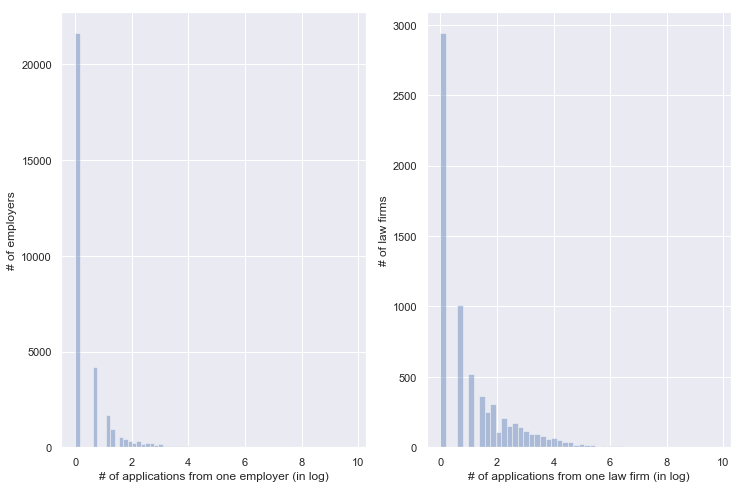

In [300]:
sns.set(color_codes=True)
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12,8))
sns.distplot(np.log(visas['EMPLOYER_NAME'].value_counts().values), kde=False, rug=False, ax=ax1)
ax1.set(xlabel='# of applications from one employer (in log)', ylabel='# of employers')
sns.distplot(np.log(visas['AGENT_FIRM_NAME'].value_counts().values), kde=False, rug=False, ax = ax2)
ax2.set(xlabel='# of applications from one law firm (in log)', ylabel='# of law firms')

What kind of jobs are applied for the most?
Top 5 jobs seems to be software area, guess the demand for these jobs are so high in the US that companies will sponsor them just to come here and work for them.

In [352]:
print(visas['JOB_INFO_JOB_TITLE'].value_counts().head(5))
display(visas[['PW_SOC_CODE', 'PW_SOC_TITLE', 'JOB_INFO_JOB_TITLE', 'PW_JOB_TITLE_9089']].head(5))

Software Engineer                   5123
Software Development Engineer II    1806
Senior Software Engineer            1256
Software Developer                  1133
Assistant Professor                  768
Name: JOB_INFO_JOB_TITLE, dtype: int64


,PW_SOC_CODE,PW_SOC_TITLE,JOB_INFO_JOB_TITLE,PW_JOB_TITLE_9089
323,45.0,"Farmworkers and Laborers, Crop, Nursery, and Greenhouse",Farmworker and Laborer,Farmworker and Laborer
335,45.0,"Farmworkers and Laborers, Crop, Nursery, and Greenhouse",Farmworker and Laborer,Farmworker and Laborer
342,45.0,"Farmworkers and Laborers, Crop, Nursery, and Greenhouse",Farmworker and Laborer,Farmworker and Laborer
343,45.0,"Farmworkers and Laborers, Crop, Nursery, and Greenhouse",Farmworker and Laborer,Farmworker and Laborer
345,45.0,"Farmworkers and Laborers, Crop, Nursery, and Greenhouse",Farmworker and Laborer,Farmworker and Laborer


Next, we'll examine the country of origin since we think that may implicitly play a role in the decision.

There's actually two variables that we think may be closely related country of citizenship and birth country. Let's test if they're related using the chi-square test.

In [302]:
country_contingency = pd.crosstab(visas['COUNTRY_OF_CITIZENSHIP'], visas['FW_INFO_BIRTH_COUNTRY'])
stats.chi2_contingency(country_contingency)[1]

0.0

Our null hypothesis is the two variables are independent. We see that the p-value outputted above is 0. Clearly we reject the null and conclude that the two are dependent, just like we thought.

Now to get a measure of the strength of association let's calculate Cramer's V (because why not?)

In [303]:
stats.chi2_contingency(country_contingency)[0] / (len(visas) * min(country_contingency.shape)) #cramer's v

0.6998986752663362

# Feature Engineering

The data transformations we have done so far were mainly to make our data more consistent. The data transformations we make here are primarily geared at improving the results of the model. Note that some features were added after running the model a few times. Model building is an iterative process.

Let's try feeding in the firm name data in a form that can help the model make better use of the information. We define a function that counts the total applications and then bins the number of applications that each firm has submitted by quartile.

In [304]:
def count_bin_transform(df, col, n_bins):
    dist_counts = df[col].value_counts().values[::-1] #in ascending order
    intvals_counts = np.arange(1, n_bins) * dist_counts.sum() / n_bins #mark even intervals from 1 to total apps
    intvals_idxs = np.zeros(n_bins-1)
    bins = np.zeros(n_bins-1)
    count = 0
    for i in intvals_counts:
        intvals_idxs[count] = (np.cumsum(dist_counts) <= i).argmin() #first value with False (0)
        intvals_idxs = intvals_idxs.astype(int)
        count += 1
    count = 0
    for i in intvals_idxs:
        bins[count] = dist_counts[i]
        count += 1
    bins = np.insert(bins, 0, 0)
    bins = np.append(bins, np.max(dist_counts))
    new_col = df[col].map(df[col].value_counts())
    #map value of x to the count of x (which has the value of x as its index)
    new_col = pd.cut(new_col, bins, right=True)
    return new_col

visas['AGFIRM_RANK'] = count_bin_transform(visas, 'AGENT_FIRM_NAME', 4)
visas['EMPFIRM_RANK'] = count_bin_transform(visas, 'EMPLOYER_NAME', 4)

See if this new feature might actually be useful

First, we're going to select only the observations with target variable 'CASE_STATUS' and throw away the others. Then we map it to a binary representation for convenience.

In [305]:
visas = visas[(visas['CASE_STATUS'] == 'Certified') | (visas['CASE_STATUS'] == 'Denied')]

visas['CASE_STATUS'] = visas['CASE_STATUS'].map(dict(Certified = 1, Denied = 0))

In [306]:
visas[['AGFIRM_RANK','CASE_STATUS']].groupby(['AGFIRM_RANK']).mean()

,CASE_STATUS
AGFIRM_RANK,
"(0.0, 33.0]",0.859737
"(33.0, 187.0]",0.943181
"(187.0, 1476.0]",0.945929
"(1476.0, 17672.0]",0.991158


It looks like small firms (firms that didn't submit many applications) lack the quality in their applications that the other quartiles have and the largest firms have a almost certain chance of getting the application right.

Note: Feature engineering just by performing simple operations across features helps. You might think that given 'DECISION_DATE' and 'PROCESS_LENGTH' that the model can just infer 'CASE_RECEIVED' but this is false, it is not that smart. Using the same logic, features that might seem redundant to you may add predictive power to the model.

In [307]:
visas['PROCESS_LENGTH'] = visas['DECISION_DATE'] - visas['CASE_RECEIVED_DATE']
visas['PROCESS_LENGTH'] = visas['PROCESS_LENGTH'].astype('timedelta64[D]')

visas['PROCESS_LENGTH'].describe()

count    78236.000000
mean       152.208676
std        217.389578
min         28.000000
25%         83.000000
50%        116.000000
75%        147.000000
max       4150.000000
Name: PROCESS_LENGTH, dtype: float64

It looks like applications on average take around 5 months to process from start to finish

Create three new features, two of which is the time in-between the application file date and date of the ads, and one for indicating whether both ads were in the specified time range.

In [308]:
visas['AD1_BW'] = (visas['CASE_RECEIVED_DATE'] - visas['RECR_INFO_FIRST_AD_START'])
visas['AD2_BW'] = (visas['CASE_RECEIVED_DATE'] - visas['RECR_INFO_SECOND_AD_START'])

To check if the two ads were on seperate occasions, we will have to assume that NaT means two things that are equivalent: no second ocassion, and the first shares the same date as the second occassion.

In [309]:
visas['RECR_INFO_SECOND_AD_START'] = visas['RECR_INFO_SECOND_AD_START'].fillna(visas['RECR_INFO_FIRST_AD_START'])

visas['AD_REQ'] = ((visas['AD1_BW'].between(pd.Timedelta(30, 'D'), pd.Timedelta(180, 'D')) == 1) & 
                   (visas['AD2_BW'].between(pd.Timedelta(30, 'D'), pd.Timedelta(180, 'D')) == 1) & 
                   (visas['RECR_INFO_FIRST_AD_START'] != visas['RECR_INFO_SECOND_AD_START']))

Many applications were denied for not following the second criteria

In [310]:
len(visas[['RECR_INFO_FIRST_AD_START', 'RECR_INFO_SECOND_AD_START', 'CASE_RECEIVED_DATE']][(visas['AD_REQ'] == 0) & (visas['CASE_STATUS'] == 0)])

428

# Model Preparation

This is our stage of data cleaning solely for the purpose of transforming the data into a format that allows us to feed it into the model.

Let's check the data types of our features

In [311]:
visas.dtypes.value_counts()

object             87
datetime64[ns]     28
float64            11
bool                2
timedelta64[ns]     2
category            1
int64               1
category            1
dtype: int64

We can see there are a lot of object types and just by looking at the unique values for some of them, there are way too many.

What we can do in this case usually is to one-hot encode, because that is the only format Sklearn accepts besides encoding each category label i.e. unique value of the object and that's not a good choice because there will be an ordinal interpretation. It turns out that one-hot encoding is also a bad choice because first the data will be excessively sparse and second, this leads to the one-hot features being underweighed just by the way how decision trees splits (one-hot can only be split one way since it is binary while there are infinitely many ways for continuous to be split).

As a side note another reason not to use a Sklearn classifier for our purposes is that it doesn't accept them, this is problematic for numerical data where there may be reasons a field is left blank and tricks like imputing the mean just doesn't make sense.

So we're actually going to use the H2o platform for our random forest model which is a lot better at handling categorical variables.

Correct for some anomalies in data:

In [312]:
visas['NAICS_US_CODE'] = visas['NAICS_US_CODE'].astype(str)
visas['NAICS_US_CODE'] = visas['NAICS_US_CODE'].apply(lambda x: x[:2])

visas['PW_SOC_CODE'] = visas['PW_SOC_CODE'].str.replace(r'(-\d+)', '')
visas['PW_SOC_CODE'] = visas['PW_SOC_CODE'].astype(float, errors='ignore')
visas['PW_SOC_CODE'] = visas['PW_SOC_CODE'].round()
#http://pandas.pydata.org/pandas-docs/stable/gotchas.html#support-for-integer-na
visas['PW_SOC_CODE'] = visas['PW_SOC_CODE'].astype(str, errors='ignore')

Split into train and test sets. We would split after converting to H2o frame, but pandas df is a lot easier for data manipulation

In [313]:
rs = ShuffleSplit(n_splits=1, test_size=.2, random_state=0)
for train_idx, test_idx in rs.split(visas):
    train = visas.iloc[train_idx]
    test = visas.iloc[test_idx]
print(train.shape, test.shape)
#visas_hf.split_frame(ratios=[.8])

(62588, 133) (15648, 133)


Start H2o

In [314]:
h2o.init(nthreads=18, min_mem_size=8, max_mem_size=20)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 day 0 hours 35 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,4 days
H2O cluster name:,H2O_from_python_gdev_gbj97k
H2O cluster total nodes:,1
H2O cluster free memory:,18.64 Gb
H2O cluster total cores:,24
H2O cluster allowed cores:,18
H2O cluster status:,"locked, healthy"


Load the pandas dataframe into H2o's frame

In [315]:
train_hf = H2OFrame(train)
test_hf = H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


Convert our target variable to 'enum' type

In [316]:
train_hf['CASE_STATUS'] = train_hf['CASE_STATUS'].asfactor()
test_hf['CASE_STATUS'] = test_hf['CASE_STATUS'].asfactor()
print(train_hf.type('CASE_STATUS'), test_hf.type('CASE_STATUS'))

enum enum


Our target variable is supposed to be binary, let's just check that's the case

In [317]:
print(train_hf['CASE_STATUS'].unique(), test_hf['CASE_STATUS'].unique())

C1
0
1


C1
0
1


Finally just exclude some columns. We're going to exclude 'DECISION_DATE' b/c that shouldn't help inform a decision when it is made

In [318]:
predictor_cols = set([col for col in train_hf.columns if col != 'CASE_STATUS'])
criteria_cols = {'OVER_PW', 'AD_REQ'}
exclude_cols = {'DECISION_DATE', 'decision_day', 'received_day', 'RECR_INFO_FIRST_AD_START', 'RECR_INFO_SECOND_AD_START'}

# Training Model

Finally we're ready to start training our model

We're going to use a simple random forest classifier. Categorical encoding is set to 'enum', seed to an arbitrary fixed number to be reproducible, max_depth to a number that's deep but not overly so (remember individual trees in RFs have low bias but high variance), and ntrees doesn't have to be high since performance peters out after a certain point anyway.

In [320]:
RF = random_forest.H2ORandomForestEstimator(ntrees=300, seed=781, max_depth=20, categorical_encoding='enum', nfolds=5)
RF.train(predictor_cols - exclude_cols, 'CASE_STATUS', training_frame=train_hf)

drf Model Build progress: |███████████████████████████████████████████████| 100%


# Evaluating Results

Predict the case status for the test data given our trained model

In [321]:
y_test = test_hf['CASE_STATUS'].as_data_frame().values.flatten()
y_result = RF.predict(test_hf)
y_pred = y_result[0].as_data_frame().values.flatten()
y_probas = y_result[2].as_data_frame().values.flatten()

print(accuracy_score(y_test, y_pred))

drf prediction progress: |████████████████████████████████████████████████| 100%
0.9729038854805726


At first glance our accuracy looks great. Except notice that baseline accuracy is already an astonishing ~92% which is blindly guessing approved for all test samples.

Even without an imbalanced dataset, accuracy could be very misleading. All it tells us is that out of all the labels we're predicting, the percentage we got right.

We can see exactly the types of classifications we got right, and misclassifications with our confusion matrix

In [322]:
print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

Predicted    0      1
Actual               
0          897    310
1          114  14327


In addition to accuracy, the data in the matrix can be summarized using the measures of precision and recall

Precision is defined as TP / (TP + FP) which means it is the number of true positive instances out of all the instances predicted to be positive.
Recall or the TPR is defined as TP / (TP + FN) and it is the number of positive instances that were correctly identified by the classifier out of all positive instances.

The "negative recall" for rejected (1-FPR) is relatively low, since it reflects the high number of false positives. We can reason why there might be a lot more false positives than false negatives. Given just the minimum requirements of passing a visa, it is possible for the model to pick up on what prevents an application from being approved. On the other hand, a lot of additional information (background factors) is needed for an application to be approved beyond just the minimum.

In [323]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1207
           1       0.98      0.99      0.99     14441

   micro avg       0.97      0.97      0.97     15648
   macro avg       0.93      0.87      0.90     15648
weighted avg       0.97      0.97      0.97     15648



In [324]:
RF.auc()

0.9709496891157645

Precision-recall area under the curve is like the PPF, all points within the curve are possible but points on the curve are the best obtainable combinations of precision and recall. So the higher the AUC the better.

Note: ROC AUC is a more popular measure, but it actually stays the same no matter the ratio of positive to negative class keeping all else constant and this is an imbalanced dataset so the precision-recall curve should be used here instead.

Let's compare between our training error and test error to see if we're overfitting

In [325]:
print('Training error: %f\nTest error: %f' % (1-RF.accuracy()[0][1], 1-accuracy_score(y_test, y_pred)))

Training error: 0.027226
Test error: 0.027096


Doesn't look like it! That's good news

# Validating Results

Let us compare between our test error and out-of-bag error to make sure our model is not leaking any data. If we were leaking data, we would do well on test data but not validation.

Note: We technically didn't have to do a CV here since we have the out-of-bag sample which came from the observations not used to fit a given bagged tree (good since CVs are time-consuming).

In [326]:
print('Test error: %f\nOut-of-bag error: %f'
      % (1-accuracy_score(y_test, y_pred), RF.scoring_history()['training_classification_error'].mean()))

Test error: 0.027096
Out-of-bag error: 0.031188


It looks like there is some difference (~15%) between the test and validation error, seems too large to be chance especially when we change the seed and see the same result.

Let's check the CV then:

In [327]:
print('CV error: %f' % (1-float(RF.cross_validation_metrics_summary()['mean'][0])))

CV error: 0.027804


Seems to be about the same now, guess we just needed more trees to have the oob error converge

# Model Selection

Now that we have our initial model and evaluated its performance and validity, this is where we would usually improve it by adjusting hyperparameters and such. However, we used a RF for simplicity and so there is not much need to adjust anything.

# Model Interpretation

H2o calculates variable importance using mean decrease in gini impurity on the oob sample. It has been observed that permutation importance is actually a more reliable way of measuring the most important variables (calculated by summing up the decrease in accuracy from omitting each feature during prediction), especially when the cardinality of some variables are very high i.e. continuous and categorical compared to others.

I believe it is the same problem faced by using one-hot-encoding, which is actually kind of off-putting since we used H2o to avoid this problem!

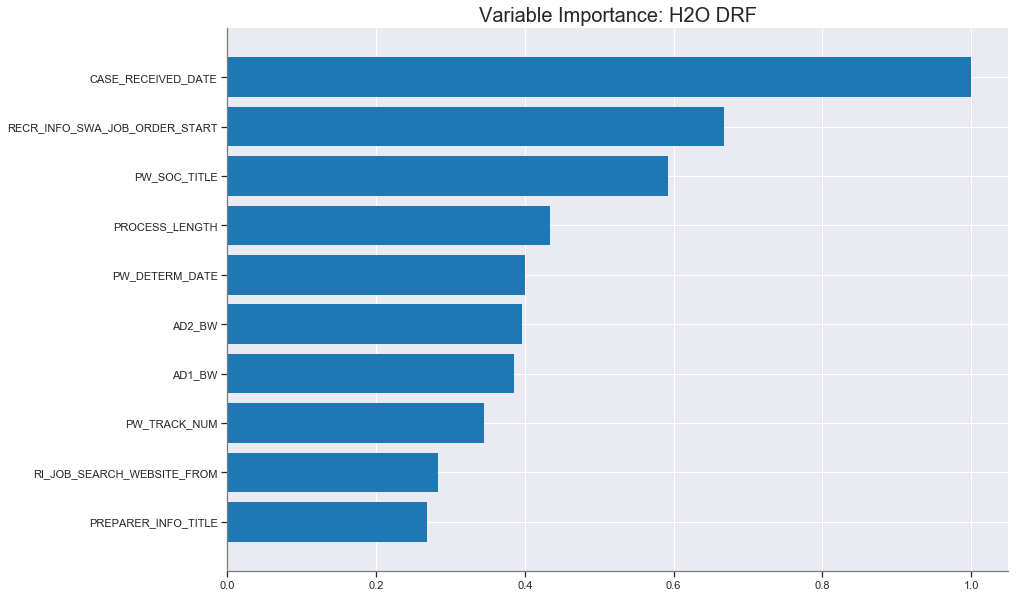

In [340]:
RF.varimp_plot()

Below we compare the distributions of the time data for the two classes, and we can see why it might be useful to the model (regions of the graph with no overlap).

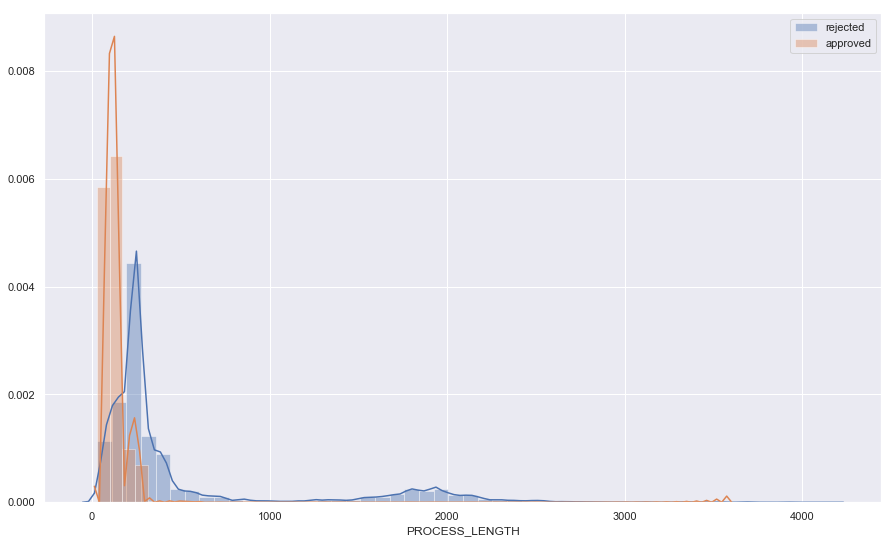

In [341]:
plt.figure(figsize=(15, 9))
sns.distplot(visas[visas['CASE_STATUS'] == 0]['PROCESS_LENGTH'])
sns.distplot(visas[visas['CASE_STATUS'] == 1]['PROCESS_LENGTH'])
plt.legend(('rejected', 'approved'))

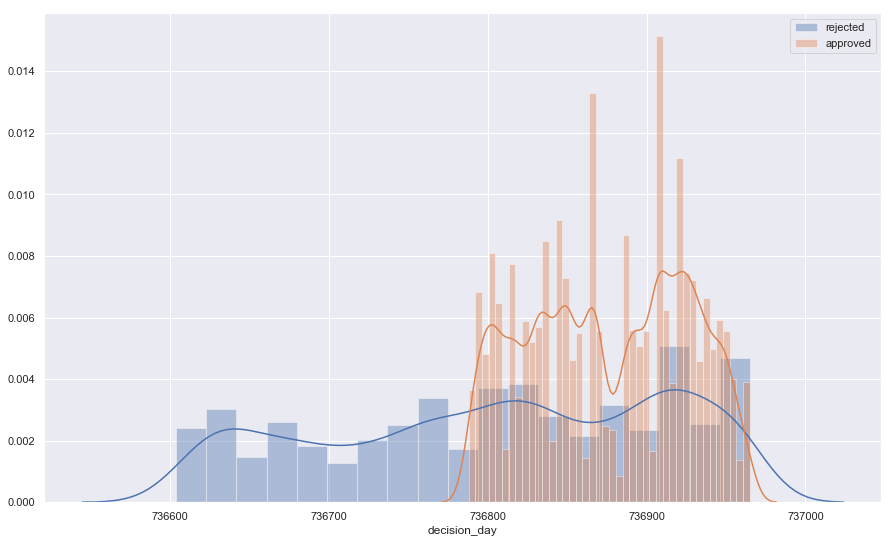

In [342]:
visas[['decision_day', 'received_day']] = visas[['DECISION_DATE', 'CASE_RECEIVED_DATE']].applymap(lambda x: x.toordinal() if pd.notnull(x) else x).astype('int64')
#FY is Oct 1 '17 - Sept 30 '18'
plt.figure(figsize=(15, 9))
sns.distplot(visas[visas['CASE_STATUS'] == 0]['decision_day'])
sns.distplot(visas[visas['CASE_STATUS'] == 1]['decision_day'])
plt.legend(('rejected', 'approved'))

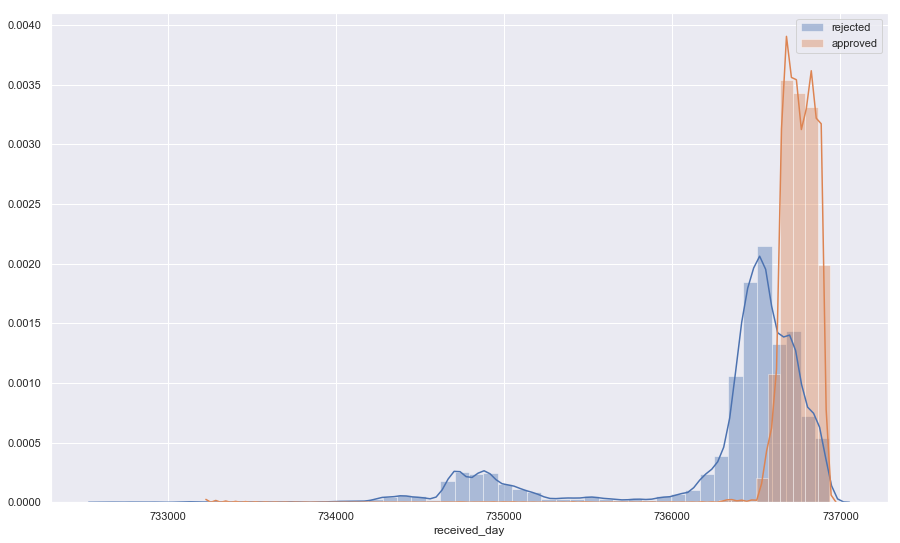

In [343]:
plt.figure(figsize=(15, 9))
sns.distplot(visas[visas['CASE_STATUS'] == 0]['received_day'])
sns.distplot(visas[visas['CASE_STATUS'] == 1]['received_day'])
plt.legend(('rejected', 'approved'))

# Final Thoughts

Remember our inital goals for this project:

To determine if in the data the criteria set by the agency are followed:
1. The offering wage has to be over the prevailing wage
2. The position advertised in newspapers ads on two seperate occassions in the specified time-frame

We answered yes for #1 from our EDA and found #2 to be mostly true. While these were useful to obtain high precision for rejected, it didn't help for classifying approved applications. Besides the criteria, we were interested in if job positions and firm representation had any effect on the outcome. We found that larger firms did tend to have higher quality applications, but it wasn't an important feature in our model. Job position, however was.